In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from hmmglm import model, nonlinearities, utils, distributions

In [26]:
def train_onehot_hmmglm(
        inf_model: model.HMMGLM,
        optimizer: torch.optim.Optimizer,
        spikes_list: torch.FloatTensor,
        convolved_spikes_list: torch.FloatTensor,
        n_epochs: int = 100,
        print_freq: int = 1,
        n_sub_epochs: int = 100
) -> torch.FloatTensor:
    
    n_samples, n_time_bins, n_neurons = spikes_list.shape

    epoch_loss_list = torch.zeros(n_epochs)
    print('epoch', 'loss')

    for epoch in range(n_epochs):
        for sample in range(n_samples):
            spikes = spikes_list[sample]
            convolved_spikes = convolved_spikes_list[sample]

            gamma, xi = inf_model.forward_backward(spikes, convolved_spikes)
            inf_model.set_adjacency_type('gumbel_softmax')
            for sub_epoch in range(n_sub_epochs):
                log_likelihood = inf_model.m_step(spikes, convolved_spikes, gamma, xi)
                loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi) - inf_model.adjacency_prior_log_likelihood()
                # loss = -inf_model.m_step(spikes, convolved_spikes, gamma, xi) - inf_model.adjacency_prior_log_likelihood() + inf_model.sampled_adjacency_entropy()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                inf_model.correct_extreme_onehot()
            inf_model.set_adjacency_type('softmax')
            epoch_loss_list[epoch] += loss.item()
        if epoch % print_freq == 0:
            print(epoch, epoch_loss_list[epoch].item(), log_likelihood, flush=True)
    
    return epoch_loss_list

In [8]:
n_hidden_states = 4

In [9]:
import os
import numpy as np
import torch
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

def preprocess_data(data_dir):
    all_sequences = []
    max_neurons = 0
    
    for subdir in os.listdir(data_dir):
        subdir_path = os.path.join(data_dir, subdir)
        if os.path.isdir(subdir_path):
            # Load spike data
            spike_data_path = os.path.join(subdir_path, f"{subdir}_SpikeData.dat")
            spike_data = np.loadtxt(spike_data_path)
            spike_times = spike_data[:, 0]
            neuron_ids = spike_data[:, 1].astype(int)
            
            # Load behavior data
            behavior_data_path = os.path.join(subdir_path, f"{subdir}_Behavior.dat")
            behavior_data = np.loadtxt(behavior_data_path)
            trial_starts = behavior_data[:, 0]
            
            # Update max_neurons
            max_neurons = max(max_neurons, neuron_ids.max() + 1)
            
            # Parameters
            bin_size = 0.02  # 20 ms
            n_time_bins = 750
            sequence_duration = 15000  # 5 seconds before + 10 seconds after
            
            for start_time in trial_starts:
                sequence_start = start_time - 5000
                sequence_end = start_time + 10000
                
                # Initialize sequence array
                sequence = np.zeros((n_time_bins, neuron_ids.max() + 1))
                
                # Bin spikes
                for neuron in range(neuron_ids.max() + 1):
                    neuron_spikes = spike_times[(neuron_ids == neuron) & 
                                                (spike_times >= sequence_start) & 
                                                (spike_times < sequence_end)]
                    binned_spikes, _ = np.histogram(neuron_spikes, bins=n_time_bins, 
                                                    range=(sequence_start, sequence_end))
                    sequence[:, neuron] = binned_spikes
                
                all_sequences.append(sequence)
    
    # Pad sequences to have the same number of neurons
    padded_sequences = []
    for seq in all_sequences:
        padded_seq = np.zeros((n_time_bins, max_neurons))
        padded_seq[:, :seq.shape[1]] = seq
        padded_sequences.append(padded_seq)
    
    # Convert to PyTorch tensor
    all_sequences = torch.FloatTensor(np.array(padded_sequences))
    
    # Split into training and testing sets
    train_sequences, test_sequences = train_test_split(all_sequences, test_size=1/3, random_state=42)
    
    return train_sequences, test_sequences, all_sequences

# Usage
data_dir = './mPFC_Data'
train_spikes, test_spikes, all_sequences = preprocess_data(data_dir)

print(f"Training data shape: {train_spikes.shape}")
print(f"Testing data shape: {test_spikes.shape}")

Training data shape: torch.Size([1889, 750, 58])
Testing data shape: torch.Size([945, 750, 58])


In [37]:
decay = 1
window_size = 5
basis = utils.exp_basis(decay=1, window_size=window_size, time_span=window_size)
print(f'basis: {basis}')
flipped_basis = torch.flip(basis, (0,))
print(f'flipped basis: {flipped_basis}')

basis: tensor([0.6364, 0.2341, 0.0861, 0.0317, 0.0117])
flipped basis: tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])


In [16]:
print(train_spikes.shape[2])

58


In [27]:
test_model1 = model.OnehotHMMGLM(
    n_states=n_hidden_states,
    n_neurons=train_spikes.shape[2],
    basis=basis
)
torch.manual_seed=0
epoch_loss_list = train_onehot_hmmglm(
    inf_model=test_model1,
    optimizer=torch.optim.Adam(test_model1.parameters(), lr=0.01),
    spikes_list=train_spikes,
    convolved_spikes_list=train_spikes,
    n_epochs=50,
    print_freq=1,
    n_sub_epochs=1
)

epoch loss
0 -380171200.0 tensor(-3559.7234, grad_fn=<AddBackward0>)
1 -554236096.0 tensor(-3064.2285, grad_fn=<AddBackward0>)
2 -562594944.0 tensor(-2963.9395, grad_fn=<AddBackward0>)
3 -566779520.0 tensor(-2933.7483, grad_fn=<AddBackward0>)
4 -570869056.0 tensor(-2924.4148, grad_fn=<AddBackward0>)
5 -571570752.0 tensor(-2937.9509, grad_fn=<AddBackward0>)
6 -566629760.0 tensor(-2931.7375, grad_fn=<AddBackward0>)
7 -567421632.0 tensor(-2969.5383, grad_fn=<AddBackward0>)
8 -569674304.0 tensor(-2975.6296, grad_fn=<AddBackward0>)
9 -572243584.0 tensor(-2967.6680, grad_fn=<AddBackward0>)
10 -567890432.0 tensor(-4159.4424, grad_fn=<AddBackward0>)
11 -567447232.0 tensor(-2974.0554, grad_fn=<AddBackward0>)
12 -568205184.0 tensor(-2981.2344, grad_fn=<AddBackward0>)
13 -571223040.0 tensor(-2998.8735, grad_fn=<AddBackward0>)
14 -571121792.0 tensor(-2973.3308, grad_fn=<AddBackward0>)
15 -566817856.0 tensor(-2978.8665, grad_fn=<AddBackward0>)
16 -567468736.0 tensor(-2966.7178, grad_fn=<AddBackward

In [28]:
def visualize_states(states: torch.LongTensor, ax):
    ax.matshow(states[None, :], vmin=0, vmax=9, cmap='tab10', aspect='auto')

Text(0.5, 0.01, 'time')

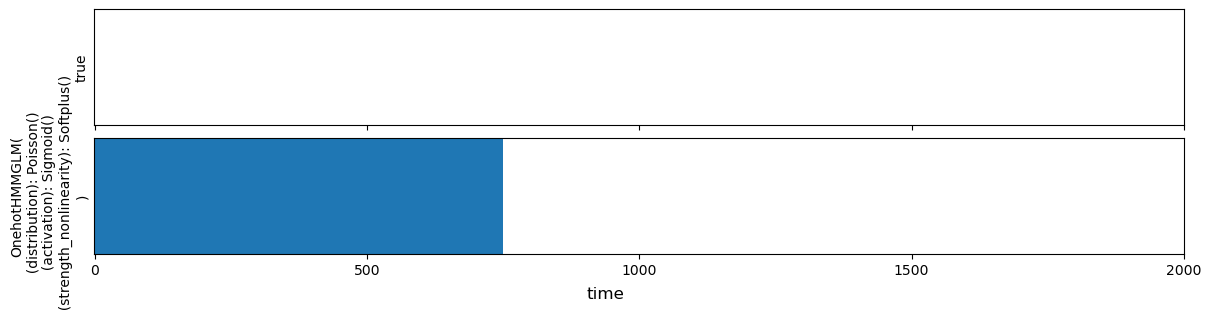

In [38]:
sample = 144

fig, axs = plt.subplots(2, 1, figsize=(12, 3), layout='constrained', sharex=True)
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=False, left=False, labelleft=False)
axs[0].set(ylabel='true')
ax = axs[1]
states_inferred = test_model1.forward_backward(test_spikes[sample], test_spikes[sample])[0].argmax(dim=-1)
visualize_states(states_inferred, ax)
ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=False, left=False, labelleft=False)
ax.set(ylabel=f'{test_model1}')
ax.tick_params(labelbottom=True)
ax.set(xticks=[0, 500, 1000, 1500, 2000])
fig.supxlabel('time')

In [36]:
print(states_inferred)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,